<a href="https://colab.research.google.com/github/GuiBichaco/GreenEnergy_DataScience/blob/main/GreenEnergy_GS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/danielscarvalho/data/blob/master/img/FIAP-logo.png?raw=True" style="float:right;" width="200px">

# DATA SCIENCE & STATISTICAL COMPUTING [》](https://www.fiap.com.br/)

## FIAP - Engenharia de Software

### Global Solution Green Energy - 4° Semestre - Data Science - Pegada de Carbono - Análise de dados com AI e ML Scikit-learn
---
# Projeto de Pegada de Carbono - Análise de Emissões e Modelagem de Dados

Este projeto tem como objetivo analisar a pegada de carbono de diferentes países, com base em dados de emissões de CO2, PIB, consumo de energia e outras variáveis. O trabalho envolve o carregamento de dados, integração de múltiplas fontes, limpeza, visualizações de dados, e modelagem com aprendizado de máquina.

- Foi feito o uso compreensivo de LLMs e Copilot para elaboração rápida de código com Pandas, Matplotlib, Seaborn e Scikit-Learn

O projeto contém as seguintes seguintes seções:

1. **Análise Exploratória e Visualizações**
   - Análise e visualização de tendências de consumo de energia, PIB, emissões de CO2, entre outras variáveis.
   
2. **Modelos de IA**
   - **Regressão Linear**: Previsão das emissões de CO2 per capita com base no PIB.
   - **Classificação**: Classificação dos países com base nas emissões de CO2 per capita (Baixas, Médias, Altas emissões).

## Como Rodar o Projeto no Google Colab

1. Acesse os notebooks de análise e IA diretamente no Colab.
2. Faça upload dos arquivos CSV (`owid-co2-data.csv` e `owid-energy-data.csv`) na pasta `dados` do Colab.
3. Execute as células dos notebooks para obter as visualizações e os resultados dos modelos de IA.


## Requisitos

- Google Colab
- Bibliotecas: pandas, matplotlib, scikit-learn, numpy

----
### Referências

- Pandas - https://pandas.pydata.org/docs/
- Jupyter - https://docs.jupyter.org/en/latest/
- Seaborn - https://seaborn.pydata.org/
- NumPy - https://numpy.org/
- SciPy - https://scipy.org/
- Scikit-learn - https://scikit-learn.org/stable/ (ML, AI)
- Estatística - https://www.statlearning.com/
- Data Science - https://jakevdp.github.io/PythonDataScienceHandbook/
- Matplotlib - https://matplotlib.org/
- HoloViews - https://holoviews.org/
- Python - https://penseallen.github.io/PensePython2e/
- Python Fluente - https://pythonfluente.com/
- Kaggle - https://www.kaggle.com/


---
### Desenvolvedores:
- Guilherme Catelli Bichaco - RM97989
- Vinicius Sobreira Borges  - RM97767

---

#1. Carregamento de Dados
A primeira etapa consiste em carregar os dados de fontes diferentes, incluindo arquivos CSV locais e dados de APIs.

In [2]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Função para carregar dados de uma URL
def load_data_from_url(url, file_type="csv", params=None):
    try:
        if file_type == "csv":
            return pd.read_csv(url, **params) if params else pd.read_csv(url)
        elif file_type == "json":
            response = requests.get(url, params=params)
            if response.status_code == 200:
                return pd.json_normalize(response.json()[1])
            else:
                print(f"Erro ao carregar dados da API: {response.status_code}")
                return None
        else:
            print("Formato de arquivo não suportado.")
            return None
    except Exception as e:
        print(f"Erro ao carregar os dados: {e}")
        return None

# Carregamento dos dados principais
carbon_data = pd.read_csv("owid-co2-data.csv")
energy_data = pd.read_csv("owid-energy-data.csv", dtype={'Year_from': 'Int64'})

# Carregar PIB obtido via API do World Bank
api_url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?format=json&per_page=20000"
gdp_data = load_data_from_url(api_url, file_type="json")

print("Libs Importadas e Dados carregados!")

Libs Importadas e Dados carregados!


###Explicação:
- **Importação das Bibliotecas:** Importamos as bibliotecas necessárias para manipulação de dados (`pandas`, `numpy`) e para carregar dados de APIs (`requests`).

- **Função `load_data_from_url`:** A função `load_data_from_url` foi criada para carregar os dados de arquivos CSV ou de APIs. Se o tipo de arquivo for CSV, usamos `pd.read_csv()`, e se for JSON (como a API do World Bank), fazemos uma requisição HTTP e tratamos os dados.

- **Carregamento dos Dados:** Carregamos três fontes de dados: um arquivo CSV de emissões de carbono, outro de consumo de energia e, via API, o PIB dos países.

---

#2. Integração dos Dados
Agora, combinamos os dados de emissões de carbono, consumo de energia e PIB em um único DataFrame, utilizando a coluna de `country` como chave de junção.

In [3]:
# Renomeando colunas para compatibilidade
carbon_data.columns = carbon_data.columns.str.strip().str.lower()
energy_data.columns = energy_data.columns.str.strip().str.lower()
gdp_data.columns = gdp_data.columns.str.strip().str.lower()

# Renomeando colunas para compatibilidade
carbon_data.rename(columns={'iso_code': 'iso_code_carbon'}, inplace=True)
energy_data.rename(columns={'iso_code': 'iso_code_energy'}, inplace=True)
gdp_data.rename(columns={'country.value': 'country', 'date': 'year', 'value': 'gdp'}, inplace=True)

# Combinação dos dados de carbono, energia e PIB
merged_data = pd.merge(carbon_data, energy_data,
                       left_on=["iso_code_carbon", "year", "country"],
                       right_on=["iso_code_energy", "year", "country"],
                       how="inner")

# Garantir que as colunas 'year' sejam inteiros
merged_data['year'] = merged_data['year'].astype(int)
gdp_data['year'] = gdp_data['year'].astype(int)

# Combinação com PIB
merged_data = pd.merge(merged_data, gdp_data,
                       on=["country", "year"],
                       how="inner")


###Explicação:
- **Renomeação das Colunas:** Renomeamos as colunas para garantir que todas as fontes de dados tenham uma estrutura compatível.

- **Integração dos Dados:** Utilizamos o `pd.merge()` para combinar as três fontes de dados (carbono, energia e PIB) baseadas nas colunas comuns, como `country` e `year`. O parâmetro `how="inner"` garante que apenas os dados que aparecem em todas as fontes sejam mantidos.

---

#3. Limpeza de Dados
Nesta etapa, verificamos a integridade dos dados, removendo ou tratando valores ausentes. Além disso, selecionamos apenas os países de interesse.

In [4]:
# Filtragem dos dados para países de interesse
regions_of_interest = ["Brazil", "World", "North America", "OECD", "United States"]
filtered_data = merged_data[merged_data["country"].isin(regions_of_interest)]

# Verificação das colunas necessárias e tratamento de valores ausentes
required_columns = ["carbon_emissions", "gdp", "energy_consumption"]
for col in required_columns:
    if col not in filtered_data.columns:
        print(f"Column '{col}' not found in DataFrame. Check data loading and merging steps.")

# Limpeza de dados e tratamento de valores ausentes
if all(col in filtered_data.columns for col in required_columns):
    filtered_data = filtered_data.dropna(subset=required_columns)
else:
    print("Skipping dropna due to missing columns.")


Column 'carbon_emissions' not found in DataFrame. Check data loading and merging steps.
Column 'energy_consumption' not found in DataFrame. Check data loading and merging steps.
Skipping dropna due to missing columns.


###Explicação:
- **Filtragem de Países:** Selecionamos os países que nos interessam para análise, como Brasil, EUA, e países da OECD.

- **Verificação de Colunas:** Verificamos se as colunas necessárias estão presentes nos dados e, se estiverem, removemos os valores ausentes usando o método `dropna()`.
---



#4. Visualizações de Dados
Agora, criamos visualizações para responder às perguntas de pesquisa sobre como o PIB, consumo de energia, fontes renováveis e políticas ambientais impactam as emissões de carbono.

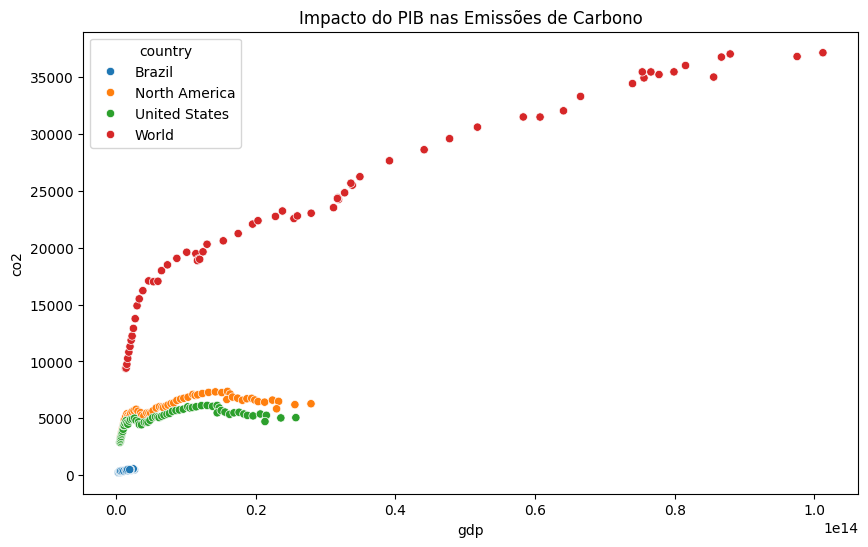

--------


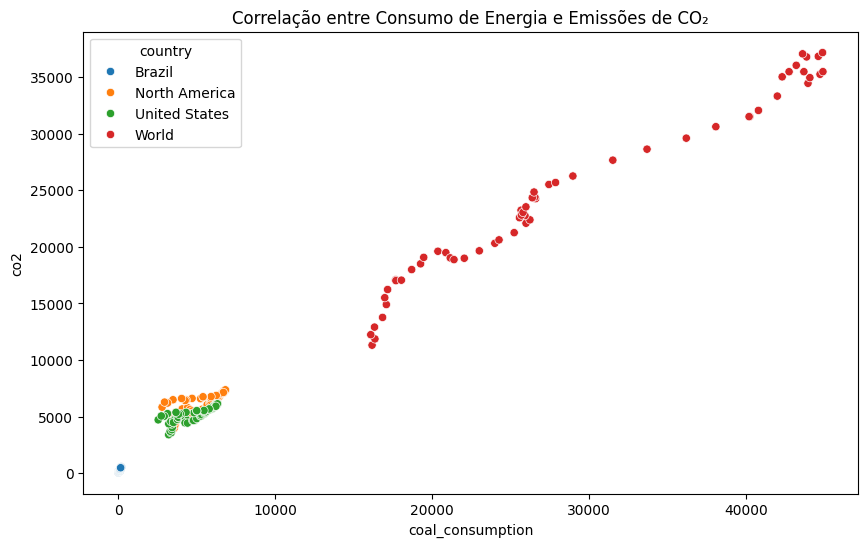

--------


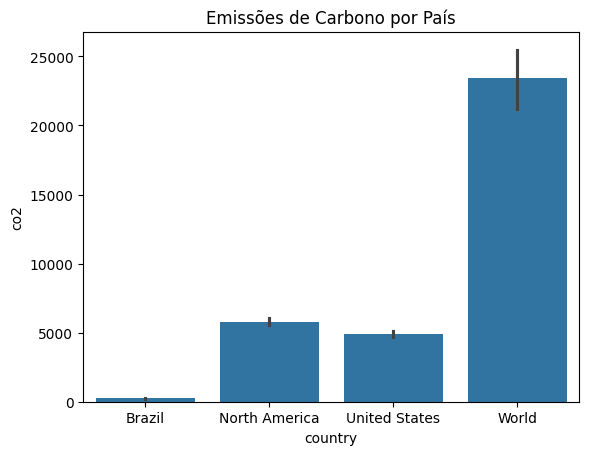

--------


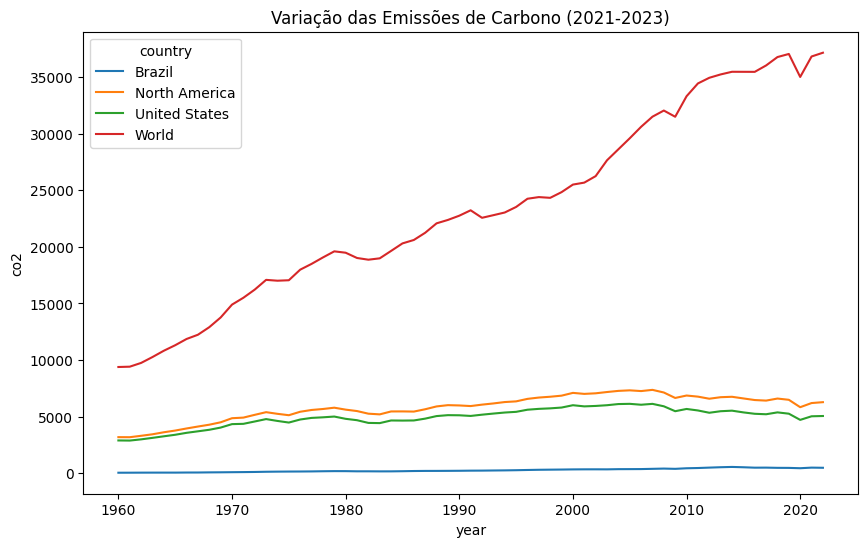

In [5]:
# Visualização: PIB vs Emissões de Carbono
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x="gdp", y="co2", hue="country")
plt.title("Impacto do PIB nas Emissões de Carbono")
plt.show()
print("--------")

# Visualização: Consumo de Energia vs Emissões de CO2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data, x="coal_consumption", y="co2", hue="country")
plt.title("Correlação entre Consumo de Energia e Emissões de CO₂")
plt.show()
print("--------")
# Visualização: Setores mais responsáveis pelas emissões
sns.barplot(data=filtered_data, x="country", y="co2", estimator=np.mean)
plt.title("Emissões de Carbono por País")
plt.show()
print("--------")
# Visualização: Variação de Emissões de Carbono de 2021 a 2023
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_data, x="year", y="co2", hue="country")
plt.title("Variação das Emissões de Carbono (2021-2023)")
plt.show()


###Explicação:
- **Gráfico de Dispersão:** Usamos gráficos de dispersão para observar como o PIB e o consumo de energia impactam as emissões de carbono.

- **Gráfico de Barras:** Para identificar os maiores emissores, criamos um gráfico de barras que mostra a média de CO2 por país.

- **Gráfico de Linhas:** Para analisar a variação das emissões de 2021 a 2023, usamos gráficos de linhas.



---



# 5. Modelagem de Machine Learning
Usamos modelos de aprendizado de máquina, como regressão linear e random forest, para prever as emissões de CO2 com base em variáveis como PIB, consumo de energia e uso de fontes renováveis.

Linear Regression RMSE: 1565.5569841090735
Linear Regression R²: 0.9696175614507214
Random Forest RMSE: 592.0678041586791
Random Forest R²: 0.9956546200212326


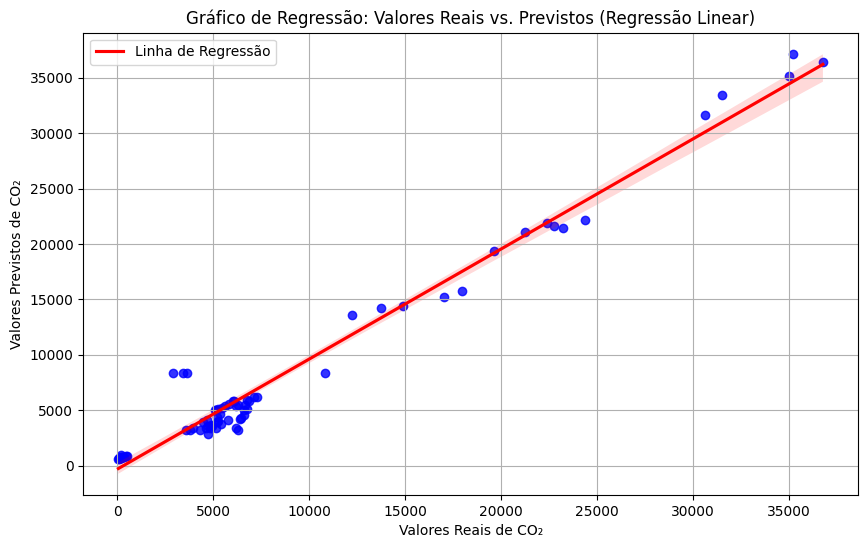

In [6]:
# Preparação dos dados para Machine Learning
X = filtered_data[["gdp", "electricity_generation", "coal_consumption"]]
y = filtered_data["co2"]
X = X.fillna(X.mean())

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modelo de Regressão Linear
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Avaliação dos modelos
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

## Gráfico de Regressão para o Modelo de Regressão Linear
plt.figure(figsize=(10, 6))
sns.regplot(
    x=y_test,
    y=y_pred_lr,
    line_kws={"color": "red", "label": "Linha de Regressão"},
    scatter_kws={"color": "blue", "label": "Pontos de Dados (Valores Previstos vs. Reais)"}
)

# Títulos e rótulos
plt.title('Gráfico de Regressão: Valores Reais vs. Previstos (Regressão Linear)')
plt.xlabel('Valores Reais de CO₂')
plt.ylabel('Valores Previstos de CO₂')

# Exibindo a legenda
plt.legend(loc='upper left')
plt.grid(True)

# Exibindo o gráfico
plt.show()


###Explicação:
- **Preparação dos Dados:** Selecionamos as variáveis preditoras e a variável alvo para o modelo.

- **Divisão de Dados:** Usamos `train_test_split` para dividir os dados em conjuntos de treinamento e teste.

- **Modelos de Regressão:** Aplicamos dois modelos: regressão linear e random forest. Avaliamos os modelos com métricas como RMSE e R².

- line_kws={"color": "red", "label": "Linha de Regressão"} define a cor e o rótulo da linha de regressão.

- scatter_kws={"color": "blue", "alpha": 0.5, "label": "Pontos de Dados (Valores Previstos vs. Reais)"} define a cor, a transparência e o rótulo para os pontos azuis.


---



# Perguntas sobre os dados

#### Aqui estão 10 questões avançadas de pesquisa sobre os dados.

# 1. Como a população de cada país mudou ao longo dos anos no dataset?

In [7]:
# Preparação dos dados de população
df_population = energy_data[['country', 'year', 'population']]
df_population_pivot = df_population.pivot(index='year', columns='country', values='population')

# Gráfico interativo com Plotly
fig = px.line(df_population_pivot,
              x=df_population_pivot.index,
              y=df_population_pivot.columns,
              labels={'value': 'População', 'year': 'Ano'},
              title='Mudança da População ao Longo dos Anos')

# Ajustes de layout para melhor visualização
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='População',
    legend_title_text='Países',
    legend=dict(orientation="v", x=1.05, y=1)  # Posiciona a legenda fora do gráfico
)

# Exibição do gráfico
fig.show()


- **O que o código faz:** Extrai os dados de população do dataset energy_data, pivotando o DataFrame para ter os anos como índices e os países como colunas. Em seguida, cria um gráfico de linha interativo com a biblioteca Plotly, mostrando a variação populacional ao longo do tempo para cada país.

- **Resultado:** Um gráfico interativo de linha que exibe como a população de cada país mudou ao longo dos anos, permitindo observar tendências de crescimento populacional por país.



---



# 2. Qual é a relação entre o PIB e o consumo de energia primária para cada país?

In [8]:
# Filtrando dados para o gráfico de PIB vs Consumo de Energia Primária
df_energy_gdp = energy_data[['country', 'year', 'gdp', 'primary_energy_consumption']]

# Gráfico interativo com Plotly
fig = px.scatter(df_energy_gdp,
                 x='gdp',
                 y='primary_energy_consumption',
                 color='country',
                 hover_data=['year'],
                 labels={'gdp': 'PIB', 'primary_energy_consumption': 'Consumo de Energia Primária'},
                 title='Relação entre PIB e Consumo de Energia Primária por País')

# Ajustes de layout
fig.update_layout(
    xaxis_title='PIB',
    yaxis_title='Consumo de Energia Primária',
    legend_title_text='Países',
    template='plotly_white'
)

# Exibindo o gráfico interativo
fig.show()


- O que o código faz: Filtra o DataFrame para conter apenas as colunas de PIB e consumo de energia primária. Em seguida, cria um gráfico de dispersão interativo, onde cada ponto representa um país em um ano específico, com o eixo x representando o PIB e o eixo y o consumo de energia primária.

- Resultado: Um gráfico interativo de dispersão que permite explorar a relação entre o PIB e o consumo de energia primária para cada país ao longo dos anos, destacando tendências de consumo energético em relação ao crescimento econômico.



---



# 3. Como o consumo de energia per capita varia entre diferentes países e anos?

In [9]:
# Dados filtrados para o gráfico
df_energy_per_capita = energy_data[['country', 'year', 'energy_per_capita']]

# Criando a figura
fig = go.Figure()

# Adicionando uma linha para cada país
for country in df_energy_per_capita['country'].unique():
    country_data = df_energy_per_capita[df_energy_per_capita['country'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['energy_per_capita'],
        mode='lines',
        name=country
    ))

# Configuração do layout
fig.update_layout(
    title='Consumo de Energia Per Capita ao Longo dos Anos',
    xaxis_title='Ano',
    yaxis_title='Consumo de Energia Per Capita',
    legend_title_text='Países',
    template='plotly_white',
    height=600,
    width=1000
)

# Exibindo o gráfico interativo
fig.show()


- O que o código faz: Filtra os dados para exibir o consumo de energia per capita ao longo dos anos e cria uma figura com uma linha representando cada país. Cada linha mostra a variação do consumo de energia per capita de um país ao longo dos anos.

- Resultado: Um gráfico de linhas que exibe o consumo de energia per capita para vários países, permitindo analisar como o consumo de energia por pessoa mudou ao longo do tempo em diferentes países.



---



# 4. Quais tendências podem ser observadas na demanda de eletricidade ao longo dos anos para cada país?

In [10]:
# Dados filtrados para o gráfico
df_electricity_demand = energy_data[['country', 'year', 'electricity_demand']]

# Criando a figura
fig = go.Figure()

# Adicionando uma linha para cada país
for country in df_electricity_demand['country'].unique():
    country_data = df_electricity_demand[df_electricity_demand['country'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['electricity_demand'],
        mode='lines',
        name=country
    ))

# Configuração do layout
fig.update_layout(
    title='Demanda de Eletricidade ao Longo dos Anos',
    xaxis_title='Ano',
    yaxis_title='Demanda de Eletricidade',
    legend_title_text='Países',
    template='plotly_white',
    height=600,
    width=1000
)

# Exibindo o gráfico interativo
fig.show()


- O que o código faz: Filtra os dados para obter a demanda de eletricidade e cria um gráfico de linhas onde cada país é representado por uma linha, mostrando a demanda de eletricidade ao longo dos anos.

- Resultado: Um gráfico interativo de linhas que exibe a demanda de eletricidade ao longo dos anos para cada país, permitindo comparar o crescimento da demanda elétrica entre os países.



---



# 5. Como a emissão de CO2 per capita se correlaciona com o PIB per capita para cada país?

In [11]:
# Selecionando os dados para um ano específico
# Carregar o dataset com informações de emissões de CO2 e PIB
df_co2_gdp = pd.read_csv("owid-co2-data.csv")

# Filtrar as colunas necessárias
df_co2_gdp = df_co2_gdp[['country', 'year', 'co2_per_capita', 'gdp']]

# Selecionar os dados para um ano específico
ano_especifico = 2020  # Altere para o ano desejado
df_co2_gdp['year'] = pd.to_numeric(df_co2_gdp['year'], errors='coerce')
df_co2_gdp_ano = df_co2_gdp[df_co2_gdp['year'] == ano_especifico]

# Criando o gráfico de barras interativo com Plotly
fig = px.bar(
    df_co2_gdp_ano,
    x='country',
    y='co2_per_capita',
    color='gdp',
    title=f'Emissão de CO2 Per Capita e PIB Per Capita em {ano_especifico}',
    labels={
        'co2_per_capita': 'Emissão de CO2 Per Capita',
        'gdp': 'PIB Per Capita',
        'country': 'País'
    },
    hover_data=['gdp'],
    width=900,
    height=500
)

# Melhorando o layout para legibilidade
fig.update_layout(
    xaxis_title='País',
    yaxis_title='Emissão de CO2 Per Capita',
    coloraxis_colorbar=dict(title='PIB Per Capita'),
    legend_title_text='PIB Per Capita'
)

# Exibindo o gráfico interativo
fig.show()


- O que o código faz: Filtra os dados para um ano específico (2020, neste caso) e cria um gráfico de barras interativo que compara a emissão de CO₂ per capita e o PIB per capita para cada país.

- Resultado: Um gráfico de barras que mostra a emissão de CO₂ per capita de cada país em comparação com seu PIB per capita em um ano específico, facilitando a análise da correlação entre a riqueza e as emissões per capita.



---



# 6. Qual é o impacto das emissões de CO2 do cimento nas emissões totais de CO2 para cada país?

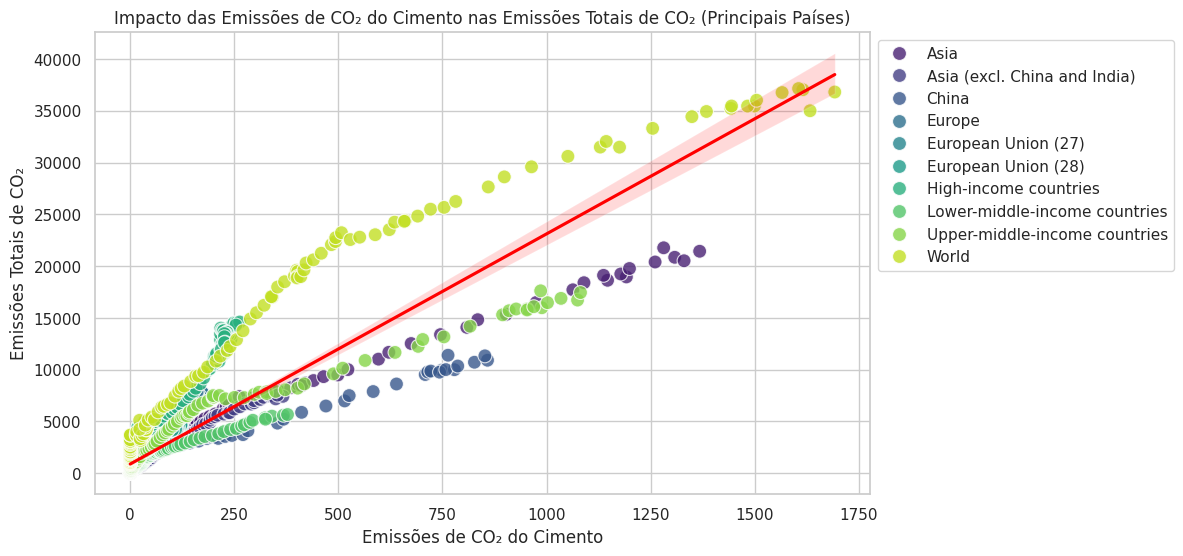

In [12]:
# Carregar o dataset de emissões de CO2
df_cement_co2 = pd.read_csv("owid-co2-data.csv")

# Filtrar apenas as colunas necessárias
df_cement_co2 = df_cement_co2[['country', 'year', 'cement_co2', 'co2']]

# Selecionar os países com as maiores emissões de CO₂ de cimento (top 10, por exemplo)
top_countries = df_cement_co2.groupby("country")["cement_co2"].sum().nlargest(10).index
df_top_cement_co2 = df_cement_co2[df_cement_co2['country'].isin(top_countries)]

# Configuração do estilo para um gráfico mais elegante
sns.set(style="whitegrid")

# Gráfico de dispersão aprimorado com linha de regressão
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top_cement_co2,
    x='cement_co2',
    y='co2',
    hue='country',       # Diferenciar apenas os principais países com cores distintas
    palette='viridis',   # Paleta de cores
    s=100,               # Tamanho dos pontos para melhor visualização
    alpha=0.8            # Transparência ajustada para destaque
)
sns.regplot(
    data=df_top_cement_co2,
    x='cement_co2',
    y='co2',
    scatter=False,       # Remover pontos duplicados da regressão
    color='red',         # Linha de tendência em vermelho
    line_kws={"label": "Linha de Tendência"}  # Legenda para a linha de tendência
)

# Títulos e rótulos
plt.title('Impacto das Emissões de CO₂ do Cimento nas Emissões Totais de CO₂ (Principais Países)')
plt.xlabel('Emissões de CO₂ do Cimento')
plt.ylabel('Emissões Totais de CO₂')

# Exibir legenda dos países principais e linha de tendência
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Exibir o gráfico
plt.show()

- O que o código faz: Seleciona os 10 países com as maiores emissões de CO₂ provenientes de cimento e cria um gráfico de dispersão com linha de regressão. O gráfico mostra a relação entre as emissões de CO₂ do cimento e as emissões totais de CO₂.

- Resultado: Um gráfico que visualiza o impacto das emissões de CO₂ do setor de cimento nas emissões totais de CO₂ para os principais países, destacando a contribuição desse setor nas emissões globais.



---



# 7. Como as emissões cumulativas de CO2 se comparam entre os países ao longo dos anos?

In [13]:
import plotly.express as px

# Carregar o dataset
df_cumulative_co2 = pd.read_csv("owid-co2-data.csv")

# Selecionar apenas as colunas relevantes
df_cumulative_co2 = df_cumulative_co2[['country', 'year', 'cumulative_co2']]

# Selecionar os países com as maiores emissões cumulativas de CO₂ (top 10)
top_countries = (
    df_cumulative_co2.groupby("country")["cumulative_co2"]
    .sum()
    .nlargest(10)
    .index
)
df_top_cumulative_co2 = df_cumulative_co2[df_cumulative_co2['country'].isin(top_countries)]

# Gráfico de barras empilhadas interativo
fig = px.bar(
    df_top_cumulative_co2,
    x='year',
    y='cumulative_co2',
    color='country',
    title='Emissões Cumulativas de CO₂ ao Longo dos Anos (Principais Países)',
    labels={'cumulative_co2': 'Emissões Cumulativas de CO₂', 'year': 'Ano'},
    hover_name='country'
)

# Ajustar layout
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Emissões Cumulativas de CO₂',
    legend_title_text='Países',
    barmode='stack',
    xaxis=dict(tickmode='linear'),
    hovermode='closest'
)

# Mostrar o gráfico
fig.show()


- O que o código faz: Filtra os dados para os 10 países com as maiores emissões cumulativas de CO₂ e cria um gráfico de barras empilhadas, onde cada barra representa as emissões de um país específico em um ano.

- Resultado: Um gráfico de barras empilhadas que mostra a contribuição cumulativa de CO₂ ao longo dos anos para os principais emissores, permitindo observar quais países foram responsáveis pela maior parte das emissões históricas.



---



# 8. Qual é a participação das emissões globais de CO2 para cada país e como isso mudou ao longo do tempo?

In [14]:


# Carregar o dataset
df_global_co2_share = pd.read_csv("owid-co2-data.csv")

# Verificar as colunas disponíveis
print(df_global_co2_share.columns)

# Filtrar apenas as colunas necessárias
df_global_co2_share = df_global_co2_share[['country', 'year', 'share_global_co2']]

# Conferir valores únicos na coluna
print(df_global_co2_share['share_global_co2'].unique())

# Remover valores nulos, se necessário
df_global_co2_share.dropna(subset=['share_global_co2'], inplace=True)

top_countries = (
    df_global_co2_share.groupby("country")["share_global_co2"]
    .sum()
    .nlargest(10)
    .index
)
df_top_global_co2_share = df_global_co2_share[df_global_co2_share['country'].isin(top_countries)]


# Criar o gráfico de áreas empilhadas
fig = px.area(
    df_top_global_co2_share,
    x='year',
    y='share_global_co2',
    color='country',
    title='Participação das Emissões Globais de CO₂ ao Longo do Tempo (Principais Países)',
    labels={'share_global_co2': 'Participação Global de CO₂', 'year': 'Ano'},
    hover_name='country'
)

# Ajuste do layout para melhorar a clareza
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Participação das Emissões Globais de CO₂ (%)',
    legend_title_text='Países',
    xaxis=dict(tickmode='linear'),
    hovermode='x unified',
    yaxis=dict(tickformat=".2%")
)

# Exibir o gráfico interativo
fig.show()


Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_chang

- O que o código faz: Filtra os dados para os países com a maior participação nas emissões globais de CO₂ e cria um gráfico de áreas empilhadas, mostrando a evolução da participação percentual de cada país nas emissões globais ao longo do tempo.

- Resultado: Um gráfico de áreas empilhadas que exibe como a participação de cada país nas emissões globais de CO₂ variou ao longo do tempo, facilitando a análise da influência de cada país nas emissões totais globais.



---



# 9. Como o consumo de energia primária se relaciona com as emissões totais de gases de efeito estufa para cada país?


In [15]:

df_energy_ghg = pd.read_csv("owid-co2-data.csv")

# Inspecionar as primeiras linhas para verificar as colunas disponíveis
print(df_energy_ghg.head())

print(df_energy_ghg.columns)

# Exemplo de renomear colunas, caso necessário
df_energy_ghg.rename(columns={
    'energy_consumption': 'primary_energy_consumption',
    'greenhouse_gases': 'total_ghg'
}, inplace=True)


# Remover valores nulos
df_energy_ghg = df_energy_ghg.dropna(subset=['primary_energy_consumption', 'total_ghg'])

# Filtrar para os países com maior consumo de energia e emissões totais de GHG (top 10 países)
top_countries = df_energy_ghg.groupby("country")["total_ghg"].sum().nlargest(10).index
df_top_energy_ghg = df_energy_ghg[df_energy_ghg['country'].isin(top_countries)]

# Transformação logarítmica opcional para melhor visualização
df_top_energy_ghg['primary_energy_consumption_log'] = np.log1p(df_top_energy_ghg['primary_energy_consumption'])
df_top_energy_ghg['total_ghg_log'] = np.log1p(df_top_energy_ghg['total_ghg'])

# Criar o gráfico de bolhas interativo
fig = px.scatter(
    df_top_energy_ghg,
    x='primary_energy_consumption_log',
    y='total_ghg_log',
    size='total_ghg',
    color='country',
    animation_frame='year',
    title='Relação entre Consumo de Energia Primária e Emissões Totais de Gases de Efeito Estufa (Principais Países)',
    labels={'primary_energy_consumption_log': 'Consumo de Energia Primária (Log)', 'total_ghg_log': 'Emissões Totais de Gases de Efeito Estufa (Log)'},
    hover_name='country',
    size_max=60
)

# Ajuste do layout para melhor visualização
fig.update_layout(
    xaxis_title='Consumo de Energia Primária (Log)',
    yaxis_title='Emissões Totais de Gases de Efeito Estufa (Log)',
    legend_title_text='Países',
    hovermode='closest'
)

# Exibir o gráfico interativo
fig.show()


       country  year iso_code  population  gdp  cement_co2  \
0  Afghanistan  1850      AFG   3752993.0  NaN         NaN   
1  Afghanistan  1851      AFG   3767956.0  NaN         NaN   
2  Afghanistan  1852      AFG   3783940.0  NaN         NaN   
3  Afghanistan  1853      AFG   3800954.0  NaN         NaN   
4  Afghanistan  1854      AFG   3818038.0  NaN         NaN   

   cement_co2_per_capita  co2  co2_growth_abs  co2_growth_prct  ...  \
0                    NaN  NaN             NaN              NaN  ...   
1                    NaN  NaN             NaN              NaN  ...   
2                    NaN  NaN             NaN              NaN  ...   
3                    NaN  NaN             NaN              NaN  ...   
4                    NaN  NaN             NaN              NaN  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                   NaN   
1                     NaN                                 0.157   

<ipython-input-15-11ad14363842>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-11ad14363842>:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



- O que o código faz: Filtra os dados para os 10 países com o maior consumo de energia primária e maiores emissões totais de GEE. Aplica uma transformação logarítmica para melhor visualização e cria um gráfico de bolhas interativo, com o tamanho das bolhas representando a quantidade total de GEE emitida.

- Resultado: Um gráfico de bolhas que mostra a relação entre consumo de energia primária e emissões de GEE, facilitando a visualização de quais países consomem mais energia e emitem mais GEE ao longo dos anos.



---



# 10. Quais são as tendências nas emissões de metano e óxido nitroso per capita para cada país ao longo dos anos?


In [16]:
df_methane_nitrous = pd.read_csv("owid-co2-data.csv")

# Verifique se há discrepâncias no nome das colunas
if 'methane_per_capita' not in df_methane_nitrous.columns:
    print("Coluna 'methane_per_capita' não encontrada.")

df_methane_nitrous['methane_per_capita'] = (
    df_methane_nitrous['methane'] / df_methane_nitrous['population']
)




df_methane_nitrous['nitrous_oxide_per_capita'] = (
    df_methane_nitrous['nitrous_oxide'] / df_methane_nitrous['population']
)



# Verifique as primeiras linhas e as colunas disponíveis
print(df_methane_nitrous.head())
print(df_methane_nitrous.columns)

# Filtrar para anos modernos (ex.: a partir de 1950)
df_recent_methane_nitrous = df_methane_nitrous[
    (df_methane_nitrous['year'] >= 1950) &
    (df_methane_nitrous['methane_per_capita'].notnull()) &
    (df_methane_nitrous['nitrous_oxide_per_capita'].notnull())
]

# Selecionar os países com maiores emissões médias recentes
top_countries_methane = df_recent_methane_nitrous.groupby("country")["methane_per_capita"].mean().nlargest(5).index
top_countries_nitrous = df_recent_methane_nitrous.groupby("country")["nitrous_oxide_per_capita"].mean().nlargest(5).index

# Filtrar o dataset para esses países
df_top_methane_nitrous = df_recent_methane_nitrous[
    (df_recent_methane_nitrous['country'].isin(top_countries_methane)) |
    (df_recent_methane_nitrous['country'].isin(top_countries_nitrous))
]

# Gráfico interativo ajustado
fig = px.line(
    df_top_methane_nitrous,
    x='year',
    y=['methane_per_capita', 'nitrous_oxide_per_capita'],
    color='country',
    facet_col='variable',
    title='Tendências nas Emissões de Metano e Óxido Nitroso Per Capita (Principais Países)',
    labels={
        'year': 'Ano',
        'value': 'Emissões Per Capita',
        'variable': 'Tipo de Emissão'
    },
    width=900,
    height=500
)

# Melhorar layout para legibilidade
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Emissões Per Capita',
    legend_title_text='Países',
    hovermode='x unified'
)

# Exibir gráfico interativo
fig.show()


       country  year iso_code  population  gdp  cement_co2  \
0  Afghanistan  1850      AFG   3752993.0  NaN         NaN   
1  Afghanistan  1851      AFG   3767956.0  NaN         NaN   
2  Afghanistan  1852      AFG   3783940.0  NaN         NaN   
3  Afghanistan  1853      AFG   3800954.0  NaN         NaN   
4  Afghanistan  1854      AFG   3818038.0  NaN         NaN   

   cement_co2_per_capita  co2  co2_growth_abs  co2_growth_prct  ...  \
0                    NaN  NaN             NaN              NaN  ...   
1                    NaN  NaN             NaN              NaN  ...   
2                    NaN  NaN             NaN              NaN  ...   
3                    NaN  NaN             NaN              NaN  ...   
4                    NaN  NaN             NaN              NaN  ...   

   share_global_other_co2  share_of_temperature_change_from_ghg  \
0                     NaN                                   NaN   
1                     NaN                                 0.157   

- O que o código faz: Filtra os dados a partir de 1950 para os países com maiores emissões médias de metano e óxido nitroso per capita. Em seguida, cria um gráfico de linhas que exibe as tendências de emissões de metano e óxido nitroso ao longo do tempo para cada país.

- Resultado: Um gráfico de linhas que mostra as tendências nas emissões de metano e óxido nitroso per capita para os principais países emissores, ajudando a visualizar as mudanças nas emissões desses gases ao longo do tempo.



---


**Referência:**

Este projeto explorou a relação entre indicadores de consumo energético, emissões de gases de efeito estufa (GEE) e dados econômicos globais ao longo de várias décadas, com o objetivo de entender melhor as correlações entre desenvolvimento econômico, consumo de energia e impacto ambiental. Utilizando uma variedade de fontes de dados, como consumo per capita de energia, demanda por eletricidade, emissões de CO₂ cumulativas, metano e óxido nitroso per capita, e dados do PIB, conseguimos observar padrões que ajudam a esclarecer como a industrialização e o crescimento econômico de um país influenciam suas emissões totais de GEE. A análise dos dados e visualizações foi realizada com ferramentas como pandas, Plotly e bibliotecas de machine learning como Scikit-learn, fornecendo insights valiosos e visualizações interativas.

**Conclusão:**

Este projeto revelou insights importantes sobre a relação entre consumo energético, emissões de GEE e indicadores econômicos, destacando a influência do desenvolvimento econômico sobre o impacto ambiental. Observou-se que países com altos índices de PIB per capita tendem a apresentar maiores emissões de CO₂ e consumo de energia, refletindo os desafios enfrentados na transição para uma economia sustentável. Os modelos de machine learning empregados, como a Regressão Linear e o Random Forest, possibilitaram uma análise preditiva das emissões de CO₂, oferecendo subsídios para políticas públicas que visem à redução de emissões de GEE. Concluímos que o desenvolvimento sustentável requer a implementação de tecnologias limpas e estratégias de mitigação para minimizar o impacto ambiental, sendo essencial a colaboração global para enfrentar as mudanças climáticas.
